# Demo of spectral extractions and analysis on an example dataset from GO-2561 (UNCOVER)

*Spectral analysis*

fitting for redshift, line flux, etc. based on the 1d spectral extraction using `msaexp`

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml

import astropy.units as u
import astropy.io.fits as pyfits

import mastquery.utils
from grizli import utils
import msaexp.slit_combine
import msaexp.spectrum
import msaexp

print('msaexp version: ', msaexp.__version__)

msaexp version:  0.9.8


In [2]:
prog = 2561
progstr = 'jw02561'
rootdir = '/data/go2561_uncover/DR250710'
os.chdir(rootdir)

outroot = 'uncover-v3'

## using the 1D spectrum on the z=4 arc

see papers by [Vanzella et al. (2022)](https://iopscience.iop.org/article/10.3847/2041-8213/ac8c2d) and [Lin et al. (2023)](https://iopscience.iop.org/article/10.3847/2041-8213/aca1c4)

In [3]:
spec_file = 'uncover-v3_prism-clear_2561_17467.spec.fits'

spec_hdu = pyfits.open(spec_file)
spec_hdu.info()

Filename: uncover-v3_prism-clear_2561_17467.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    395   501R x 10C   [D, D, D, D, D, D, D, D, D, D]   
  2  SCI           1 ImageHDU       370   (501, 27)   float64   
  3  WHT           1 ImageHDU       370   (501, 27)   float64   
  4  PROFILE       1 ImageHDU       370   (501, 27)   float64   
  5  PROF1D        1 BinTableHDU     25   27R x 3C   [D, D, D]   
  6  BACKGROUND    1 ImageHDU       370   (501, 27)   float64   
  7  SLITS         1 BinTableHDU    107   17R x 49C   [55A, K, K, D, D, D, D, D, K, 10A, D, D, D, D, 3A, K, K, D, D, K, K, K, K, K, K, K, 4A, 5A, 5A, 29A, K, K, D, K, K, K, 12A, D, D, D, D, 17A, K, K, 25A, K, K, D, D]   


In [4]:
spec = utils.read_catalog(spec_file)
spec.info()

<GTable length=501>
    name     dtype  unit    class     n_bad
----------- ------- ---- ------------ -----
       wave float64   um       Column     0
       flux float64  uJy MaskedColumn    77
        err float64  uJy MaskedColumn    77
        sky float64  uJy MaskedColumn    77
  path_corr float64      MaskedColumn    77
       npix float64            Column     0
  norm_corr float64      MaskedColumn    77
   flux_sum float64            Column     0
profile_sum float64            Column     0
    var_sum float64            Column     0


# Plot the spectrum

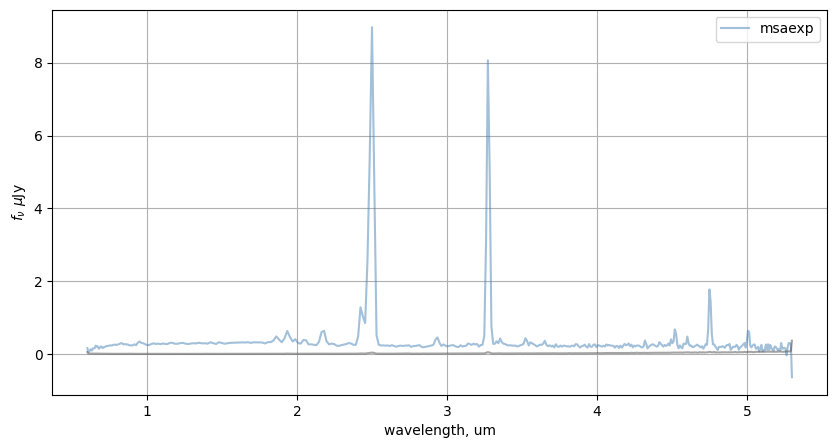

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

pl = ax.plot(spec['wave'], spec['flux'], label='msaexp', color='steelblue', alpha=0.5)
ax.plot(spec['wave'], spec['err'], color='0.3', alpha=0.5)

ax.legend()

ax.set_xlabel('wavelength, um')
ax.set_ylabel(r'$f_\nu$ $\mu$Jy')
ax.grid()

# Fitting templates to MSAEXP spectra

# (2025-07-10 01:48:31.435)

spectrum.fit_redshift(**{'file': 'uncover-v3_prism-clear_2561_17467.spec.fits', 'z0': [1, 6], 'zstep': None, 'nspline': None, 'scale_disp': 1.3, 'vel_width': 100, 'Rline': None, 'is_prism': False, 'use_full_dispersion': False, 'ranges': None, 'sys_err': 0.02, 'kwargs': {'scale_uncertainty_kwargs': {}}, 'froot': 'uncover-v3_prism-clear_2561_17467'})



627it [00:58, 10.76it/s]
101it [00:06, 14.51it/s]


calc_uncertainty_scale: Mask additional 10 pixels
calc_uncertainty_scale: sys_err = 0.0200
calc_uncertainty_scale: coeffs = [0.05101203]
calc_uncertainty_scale: NMAD = 0.995
calc_uncertainty_scale: Set SCALE_UNCERTAINTY: [0.05101203]

# line flux err
# flux x 10^-20 erg/s/cm2
# uncover-v3_prism-clear_2561_17467.spec.fits
# z = 3.98600
# Thu Jul 10 01:49:41 2025
            line Lya     -900.9 ±    583.9 (EW=    -55.2)
      line OIII-1663      272.6 ±     98.7 (EW=     23.3)
      line NIII-1750      -62.3 ±     96.1 (EW=     -6.0)
      line CIII-1906      823.7 ±     98.5 (EW=     97.1)
           line MgII       -5.8 ±     64.1 (EW=     -1.3)
       line NeV-3346       22.5 ±     49.3 (EW=      6.6)
      line NeVI-3426       -3.2 ±     47.3 (EW=     -1.0)
            line OII      534.6 ±     50.4 (EW=    196.4)
       line HeI-3889      902.7 ±     50.7 (EW=    378.3)
     line NeIII-3968      204.2 ±     39.4 (EW=     91.7)
             line Hd      309.9 ±     37.8 (EW=    156.7

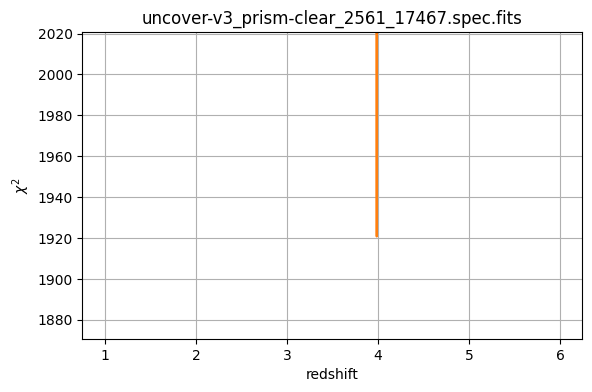

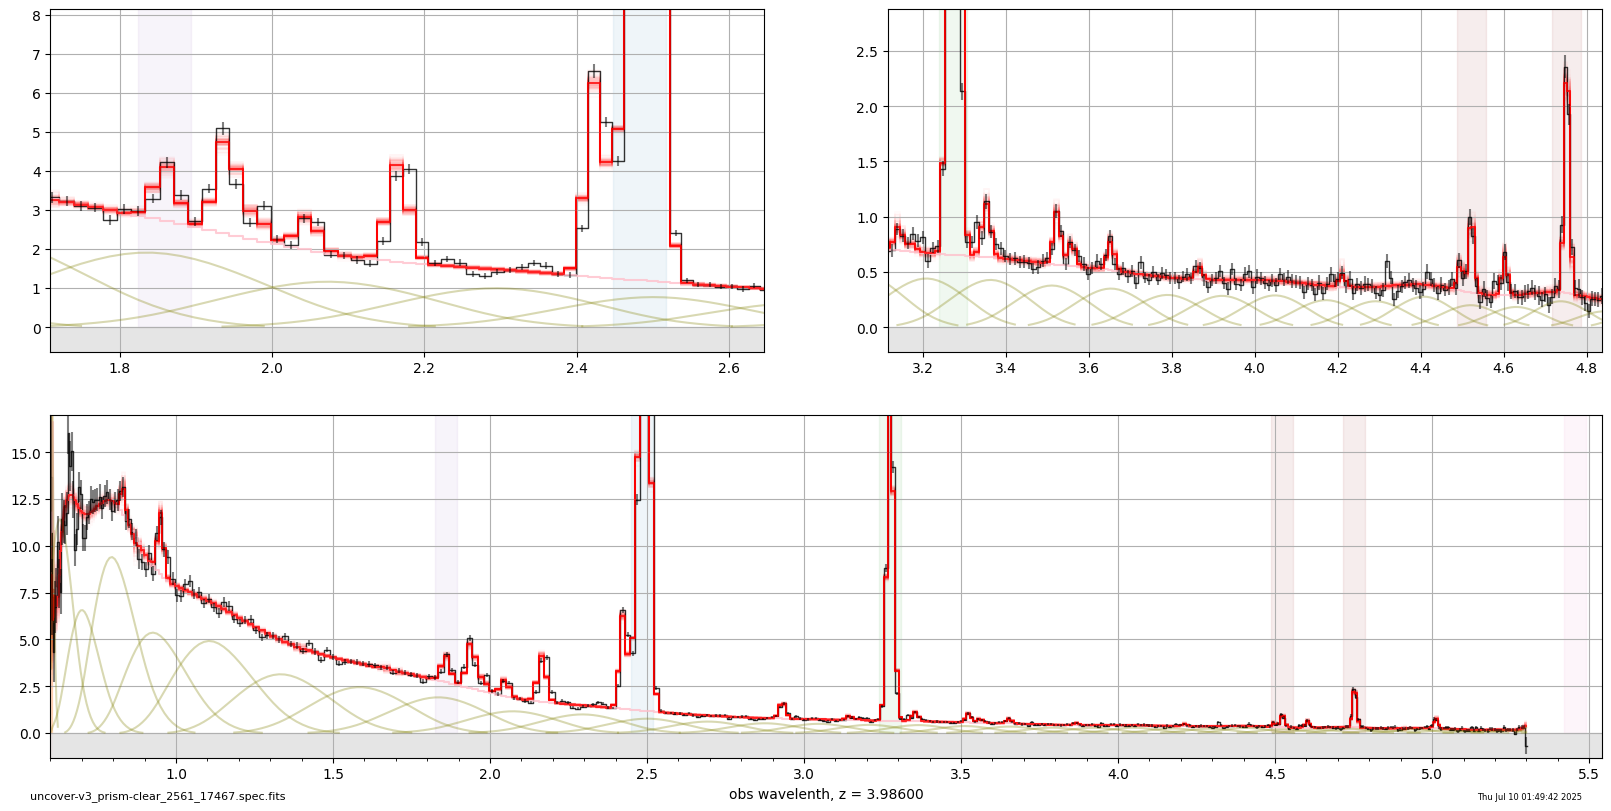

In [7]:
fig, fit_table, fit_result = msaexp.spectrum.fit_redshift(
    spec_file,
    z0=[1,6],
    scale_uncertainty_kwargs={},
)

## Fitting pieces

In [8]:
# Spectrum object - read the spectrum table and add helper methods for fitting
sampler = msaexp.spectrum.SpectrumSampler(spec_file)

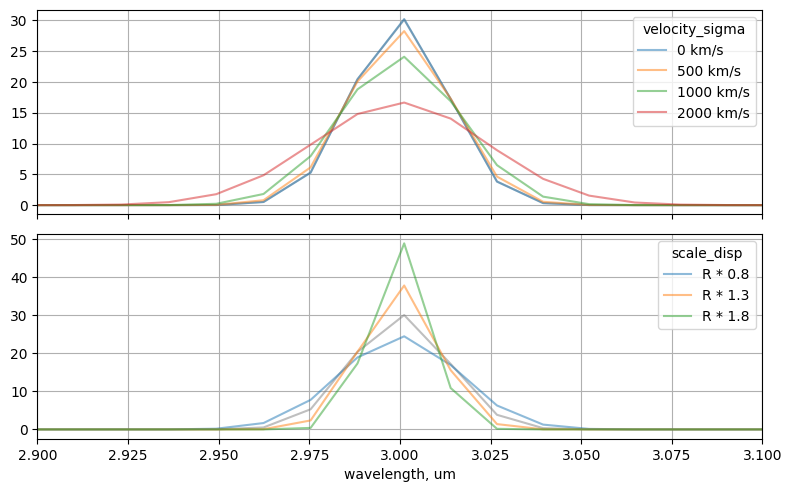

In [9]:
# Generate a single emission line

line_wave = 3.0 # microns

line_i = sampler.fast_emission_line(
    line_wave,
    line_flux=1.0,
    scale_disp=1.0,
    velocity_sigma=100,
)

fig, axes = plt.subplots(2,1,figsize=(8,5), sharex=True)
for ax in axes:
    ax.plot(sampler['wave'], line_i, color='0.5', alpha=0.5)

# Vary line velocity
ax = axes[0]
for velocity_sigma in [0, 500, 1000, 2000]:
    line_i = sampler.fast_emission_line(
        line_wave,
        line_flux=1.0,
        scale_disp=1.0,
        velocity_sigma=velocity_sigma,
    )
    axes[0].plot(sampler['wave'], line_i, label=f'{velocity_sigma} km/s', alpha=0.5)

leg = ax.legend()
leg.set_title('velocity_sigma')

# Vary scale_disp
ax = axes[1]
for scale_disp in [0.8, 1.3, 1.8]:
    line_i = sampler.fast_emission_line(
        line_wave,
        line_flux=1.0,
        scale_disp=scale_disp,
        velocity_sigma=100,
    )
    axes[1].plot(sampler['wave'], line_i, label=f'R * {scale_disp:.1f}', alpha=0.5)

leg = ax.legend()
leg.set_title('scale_disp')

for ax in axes:
    ax.grid()
    ax.set_xlim(line_wave - 0.1, line_wave + 0.1)

ax.set_xlabel('wavelength, um')
fig.tight_layout(pad=1)


In [10]:
# Spline functions for continuum
nspline = 21
bsplines = sampler.bspline_array(nspline=nspline, get_matrix=True)

In [11]:
# Helper for generating emission lines
z = fit_result['z']
_ = msaexp.spectrum.make_templates(sampler, z, bspl=bsplines)
templ_names, is_em_line, templ_matrix = _

print('\n'.join(templ_names))

spl 0
spl 1
spl 2
spl 3
spl 4
spl 5
spl 6
spl 7
spl 8
spl 9
spl 10
spl 11
spl 12
spl 13
spl 14
spl 15
spl 16
spl 17
spl 18
spl 19
spl 20
line Lya
line OIII-1663
line NIII-1750
line CIII-1906
line MgII
line NeV-3346
line NeVI-3426
line OII
line HeI-3889
line NeIII-3968
line Hd
line Hg
line Hb
line OIII
line HeI-5877
line OI-6302
line Ha+NII
line SII
line HeI-7065
line ArIII-7138
line OII-7325
line ArIII-7753
line HeI-8446
line Pa10
line SIII-9068
line Pa9
line SIII-9531
line Pa8
line CI-9850
line PaD


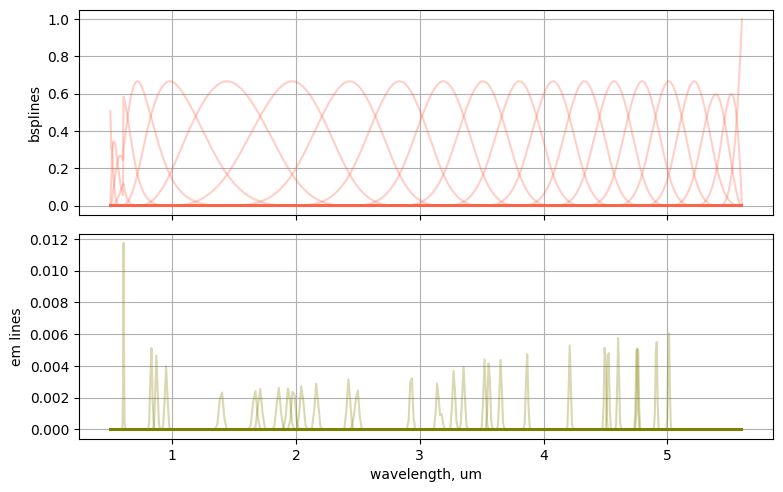

In [12]:
fig, axes = plt.subplots(2,1,figsize=(8,5), sharex=True)
_ = axes[0].plot(sampler['wave'], templ_matrix[~is_em_line].T, alpha=0.3, color='tomato')
axes[0].set_ylabel('bsplines')

_ = axes[1].plot(sampler['wave'], templ_matrix[is_em_line].T, alpha=0.3, color='olive')
axes[1].set_ylabel('em lines')
for ax in axes:
    ax.grid()

ax.set_xlabel('wavelength, um')
fig.tight_layout(pad=1)

### Fit the template matrix to the spectrum with least squares


In [13]:
# Weighted by uncertainties
A = (templ_matrix / sampler['full_err']).T
b = sampler['flux'] / sampler['full_err']

coeffs = np.linalg.lstsq(A[sampler['valid'],:], b[sampler['valid']], rcond=None)

model = templ_matrix.T.dot(coeffs[0])
model_components = templ_matrix.T*coeffs[0]

# Mask for plot
model_components[model_components < 1.e-3] = np.nan

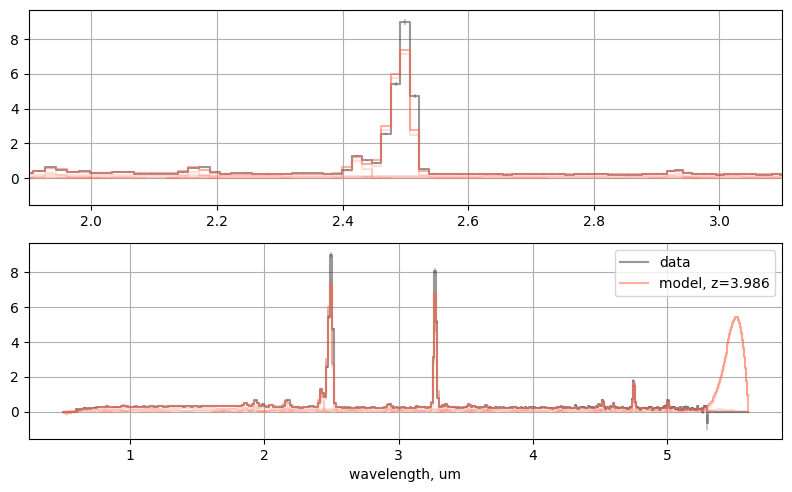

In [14]:
fig, axes = plt.subplots(2,1,figsize=(8,5))

for ax in axes:
    _ = ax.errorbar(sampler['wave'], sampler['flux'], sampler['full_err'],
                    linestyle='None', alpha=0.3, color='0.3', marker='None')
    
    ax.step(sampler['wave'], sampler['flux'], color='0.2', where='mid', alpha=0.5, label='data')
    
    ax.step(sampler['wave'], model, color='tomato', where='mid', alpha=0.5, label=f'model, z={z:.3f}')
    ax.step(sampler['wave'], model_components, color='tomato', where='mid', alpha=0.2)
    
    ax.grid()

axes[0].set_xlim(1.9, 3.1)

ax.legend()
ax.set_xlabel('wavelength, um')
fig.tight_layout(pad=1)
